## Run MW GCs through my photometric metallicity calculations

### 47 tuc has a mean metallicity of [Fe/H] = -0.75. 
References: 

Koch, A. & McWilliam, A., A New Abundance Scale for the Globular Cluster 47 Tuc
Astron. J., 135, 1551–1566 (2008)

McWilliam, A. & Bernstein, R. A., Globular Cluster Abundances from High-Resolution
Integrated-Light Spectra. I. 47 Tuc Astrophys. J., 684, 326-347 (2008)

Carretta, E., et al. Intrinsic iron spread and a new metallicity scale for globular clusters
Astron. Astrophys., 508, 695–706 (2009)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines
import matplotlib.colors as clr
from scipy.stats import kde
from scipy.stats import kde
from scipy.ndimage import gaussian_filter

In [2]:
#function to deredden SMASH data
def deredden(u,g,r,i,ebv):
    
    u0 = (u-(4.239*ebv))
    g0 = (g-(3.303*ebv))
    i0 = (i-(1.263*ebv))
    r0 = (r-(2.285*ebv))
    
    return u0,g0,i0,r0

In [3]:
#this function generates contours based on KDE map of input stars
def contour(u_g,g_r,bins,length,levels):
    hess = stats.binned_statistic_2d(u_g,g_r,None,'count',bins=bins)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='jet')
    cb = fig.colorbar(im,ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title('Raw Binned Image',fontsize=25)
    ax.set_ylabel('$(u-g)_0$',fontsize=25)
    ax.set_xlabel('$(g-r)_0$',fontsize=25)
    ticklabs = cb.ax.get_yticks()
    cb.ax.set_yticklabels(ticklabs, fontsize=15)
    cb.ax.set_title('Stellar \n Density',fontsize=15)
    plt.show(block=False)
    
    result = gaussian_filter((hess.statistic),sigma=3)


    
    xx,yy = np.mgrid[hess.x_edge.min():hess.x_edge.max():length, hess.y_edge.min():hess.y_edge.max():length]

    #levels = [(np.mean(result)+(index*np.std(result))) for index in np.arange(1,11,1)]
    levels = levels
    fig, ax = plt.subplots(figsize=(10,10))
    
    rcs = ax.contour(xx,yy,result,levels=levels,cmap='gray')
    
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,result.T,cmap='jet')
    cb = fig.colorbar(im,ax=ax)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel('$(u-g)_0$',fontsize=25)
    ax.set_xlabel('$(g-r)_0$',fontsize=25)
    ticklabs = cb.ax.get_yticks()
    cb.ax.set_yticklabels(ticklabs, fontsize=15)
    cb.ax.set_title('Stellar \n Density',fontsize=15)
    
    
    return xx,yy,result,levels

In [4]:
#this function shows density of field stars with input calibration
def density(u_g,g_r,xx,yy,result,levels,bins):

    fig, ax = plt.subplots(figsize=(15,10))
    hess = stats.binned_statistic_2d(u_g, g_r, None, 'count',bins=bins)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='gray',norm=clr.LogNorm(),label='Density of Stars')
    ax.contour(xx,yy,result,levels=levels,cmap='spring',label='Density of Calibration Sample')
    #cb = fig.colorbar(im,ax=ax,label='Density of Stars')
    cb = fig.colorbar(im,ax=ax)
    ax.set_xlabel('$(u-g)_0$',fontsize=40)
    ax.set_ylabel('$(g-r)_0$',fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_title('Density of stars w/ cal. sample overlaid',fontsize=40)
    ax.set_xlim(-.5,2.7)
    ax.set_ylim(-.5,1.6)
    #plt.legend(fontsize=20)
    ticklabs = cb.ax.get_yticks()
    cb.ax.set_yticklabels(ticklabs, fontsize=25)
    plt.plot(block=False)
    
    return 0 
    
 

In [5]:
#this function shows scatter plot of field stars with input calibration
def scatter(u_g,g_r,u_g_cal,g_r_cal):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.scatter(u_g_cal,g_r_cal,c='r',label='calibration')
    ax.scatter(u_g,g_r,c='b',s=1,label='field')
    ax.set_xlabel('$(u-g)_0$',fontsize=40)
    ax.set_ylabel('$(g-r)_0$',fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_title('scatter plot of stars over cal. sample',fontsize=40)
    ax.set_xlim(-.5,2.7)
    ax.set_ylim(-.5,1.6)
    plt.legend(fontsize=20)
    plt.plot(block=False)
    
    return 0 

In [26]:
def cmd(u,g,i):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(g-i,g,s=0.1)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title('CMD',fontsize=30)
    ax.set_ylabel('$g_0$',fontsize=25)
    ax.set_xlabel('$(g-i)_0$',fontsize=25)
    ax.set_xlim(-2,4)
    ax.set_ylim(26.5,13.5)
    plt.show(block=False)      
    
    return 0

In [6]:
#this function makes a straight line cut to select main-sequence
def select_MS(u,g,i,r,m,yx):
    
    #for straight line on plot
    x_line = np.arange(-4,6,.01)
    y_line = m*x_line + yx
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(g-i,g,s=0.1)
    ax.plot(x_line,y_line,c='r')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title('stars w/ MS line',fontsize=30)
    ax.set_ylabel('$g_0$',fontsize=25)
    ax.set_xlabel('$(g-i)_0$',fontsize=25)
    ax.set_xlim(-2,4)
    ax.set_ylim(26.5,13.5)
    plt.show(block=False)
        
    selected=np.where((g>((m)*(g-i)+yx)))
    u,g,r,i=u[selected],g[selected],r[selected],i[selected]

    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(g-i,g,s=0.1)
    ax.set_title('selected MS',fontsize=30)
    ax.set_ylabel('$g_0$',fontsize=25)
    ax.set_xlabel('$(g-i)_0$',fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlim(-2,4)
    ax.set_ylim(26.5,13.5)
    
    return u,g,i,r

In [8]:
#function to make histograms of two variables
def histograms(var1,var2,name1,name2):
    
    fig, ax = plt.subplots(1,2,figsize=(20,15))
    
    ax[0].hist(var1,bins=50)
    ax[0].set_title(name1+' histogram',fontsize=40)
    ax[0].tick_params(axis='both', which='major', labelsize=30)
    
    ax[1].hist(var2,bins=100)
    ax[1].set_title(name2+' histogram',fontsize=40)
    ax[1].tick_params(axis='both', which='major', labelsize=30)
    
    return 0

In [43]:
#function to read metallicity of original calibration sample or isochrone data
def metallicity_map(field,u_g,g_r,xedge,yedge,statistic):
    ind, = np.where(((u_g)>=xedge.min())&((u_g)<=xedge.max())&((g_r)>=yedge.min())&((g_r)<=yedge.max()))
    ix = np.searchsorted(xedge,(u_g)[ind])
    ix = ix - 1
    iy = np.searchsorted(yedge,(g_r)[ind])
    iy = iy - 1
    feh = statistic[ix,iy]
    

    
    fig, ax = plt.subplots(figsize=(10,10))
    y = ax.hist(feh,bins=100,alpha=0.3)
    ax.plot((np.nanmedian(feh))*np.ones(len(np.arange(0,100000))),np.arange(0,100000),'r',linewidth=4,label='median [Fe/H]='+str(np.nanmedian(feh)))
    ax.set_title('Map [Fe/H] hist. for field '+field,fontsize=30)
    ax.set_ylim(0,y[0].max())
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(fontsize=25)
        
    return feh 

In [57]:
#input the median colors, then read off value from either metallicity map
def metallicity_map_median(field,u_g,g_r,xedge,yedge,statistic):
    ix = np.searchsorted(xedge,u_g)
    ix = ix - 1
    iy = np.searchsorted(yedge,g_r)
    iy = iy - 1
    feh = statistic[ix,iy]
    fig, ax = plt.subplots(figsize=(10,10))
    y = ax.hist(feh,bins=100,alpha=0.3)
    ax.plot((np.nanmedian(feh))*np.ones(len(np.arange(0,100000))),np.arange(0,100000),'r',linewidth=4,label='median [Fe/H]='+str(np.nanmedian(feh)))
    ax.set_title('Map [Fe/H] hist. for field '+field,fontsize=30)
    ax.set_ylim(0,y[0].max())
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(fontsize=25)
      
    return feh

In [52]:
#nearest neighbors metallicity caluculation
def metallicity_nn(field,u_g,g_r,feh_training,u_g_training,g_r_training,leaves):
    points = np.reshape((np.ravel([u_g_training,g_r_training],order='F')),(len(u_g_training),2))
    sample = np.reshape(np.ravel([u_g,g_r],order='F'),(len(u_g),2))   
    knn = neighbors.KNeighborsRegressor(leaves,weights='uniform')
    feh = knn.fit(points,feh_training).predict(sample)
    

    fig, ax = plt.subplots(figsize=(10,10))
    y = ax.hist(feh,bins=100,alpha=0.3)
    ax.plot((np.nanmedian(feh))*np.ones(len(np.arange(0,100000))),np.arange(0,100000),'r',linewidth=4,label='median [Fe/H]='+str(np.nanmedian(feh)))
    ax.set_ylim(0,y[0].max())
    ax.set_title('NN [Fe/H] hist. for field, '+field,fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(fontsize=25)   
    return feh

In [15]:
#upload calibration sample
data = '/Users/amyel/research/SMASH_project/datafiles/new_SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()
u_cal,g_cal,i_cal,r_cal = deredden(objs["U"],objs["G"],objs["R"],objs["I"],objs["EBV"])
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal
feh_cal = objs["FEH"]

In [16]:
#upload PARSEC isochrone data for Fe/H calc
data = '/Users/amyel/research/SMASH_project/datafiles/parsec_decamsdss_3.0gyr.fits.gz'
fx = fitsio.FITS(data)
objs = fx[1].read()

u_des = objs['DECAM_U']
g_des = objs['DES_G']
r_des = objs['DES_R']
i_des = objs['DES_I']
z_des = objs['DES_Z']
feh_des = objs['FEH']
u_g_des = u_des - g_des
g_r_des = g_des - r_des

u_g_des = u_g_des + .3
#apply shift found in isochrone_minimize_residuals_01OCT2019
u_g_des = u_g_des - .005
g_r_des = g_r_des - .005

selected = np.where(g_r_des <= 1.2)
u_g_des = u_g_des[selected]
g_r_des = g_r_des[selected]
feh_des = feh_des[selected]

### 47 tuc has a mean metallicity of [Fe/H] = -0.75. 
References: 

Koch, A. & McWilliam, A., A New Abundance Scale for the Globular Cluster 47 Tuc
Astron. J., 135, 1551–1566 (2008)

McWilliam, A. & Bernstein, R. A., Globular Cluster Abundances from High-Resolution
Integrated-Light Spectra. I. 47 Tuc Astrophys. J., 684, 326-347 (2008)

Carretta, E., et al. Intrinsic iron spread and a new metallicity scale for globular clusters
Astron. Astrophys., 508, 695–706 (2009)

In [90]:
#upload 47 tuc stars from SMASH catalogues
data = '/Users/amyel/research/SMASH_project/datafiles/47tuc_stars.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()
u_47,g_47,i_47,r_47 = deredden(objs["U"],objs["G"],objs["R"],objs["I"],objs["EBV"])

index = np.where((~np.isnan(u_47)) & (~np.isnan(g_47)) & (~np.isnan(i_47)) & (~np.isnan(r_47)))
u_47 = u_47[index]
g_47 = g_47[index]
i_47 = i_47[index]
r_47 = r_47[index]

index = np.where((u_47<=30) & (u_47>=-30) & (g_47<=30) & (g_47>=-30) & (i_47<=30) & (i_47>=-30) & (r_47<=30) & (r_47>=-30))
u_47 = u_47[index]
g_47 = g_47[index]
i_47 = i_47[index]
r_47 = r_47[index]


u_g_47 = u_47 - g_47
g_r_47 = g_47 - r_47

In [91]:
xx={}
yy={}
result={}
levels={}

### Density and contours of my original calibration sample

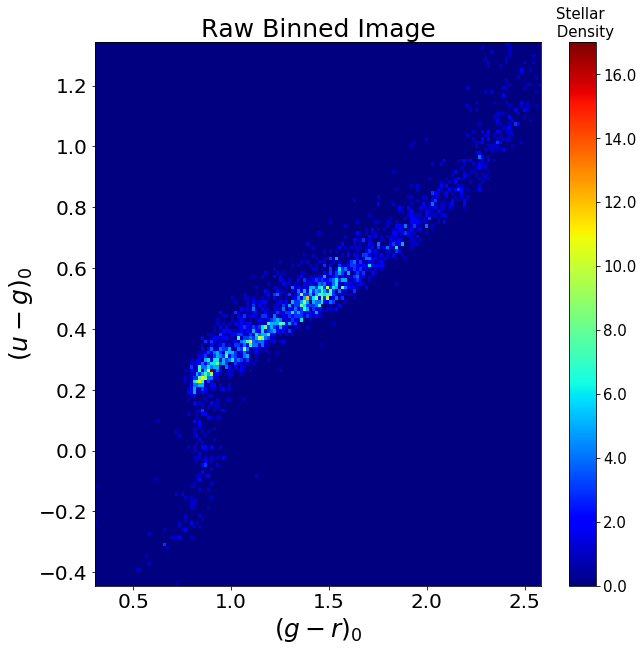

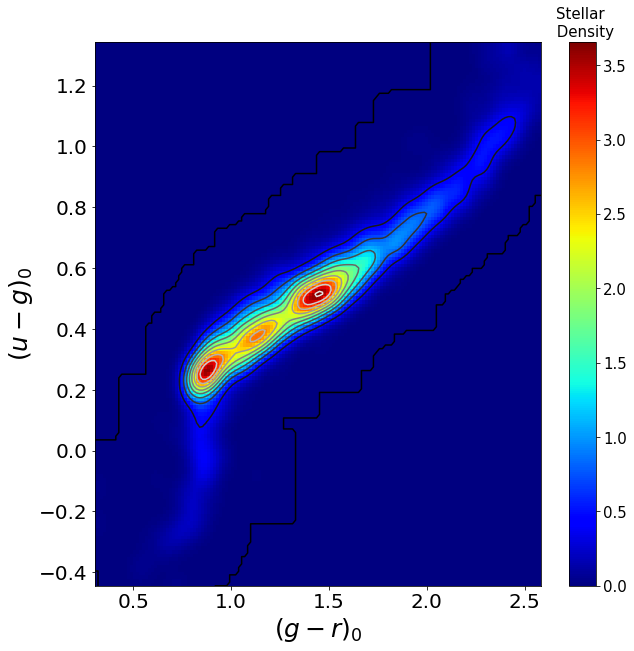

In [92]:
xx['cal'],yy['cal'],result['cal'],levels['cal'] = contour(u_g_cal,g_r_cal,150,150j,10)

### Denisty and contours of the PARSEC isochrone data

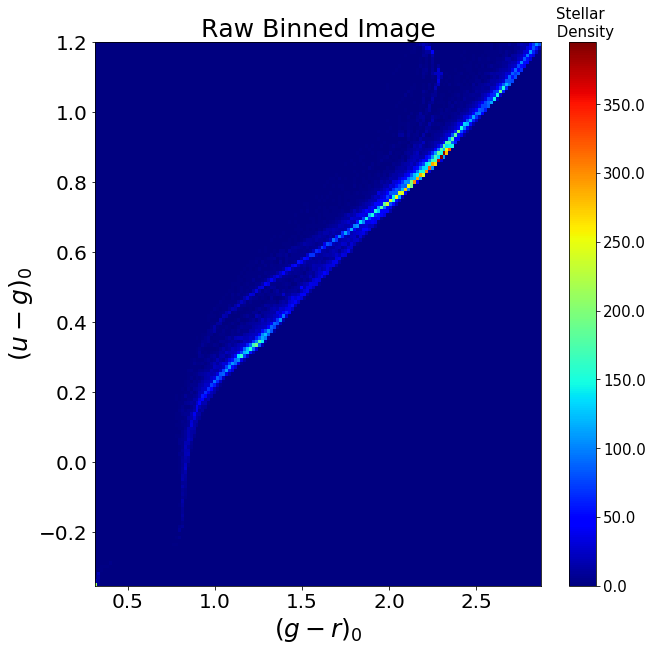

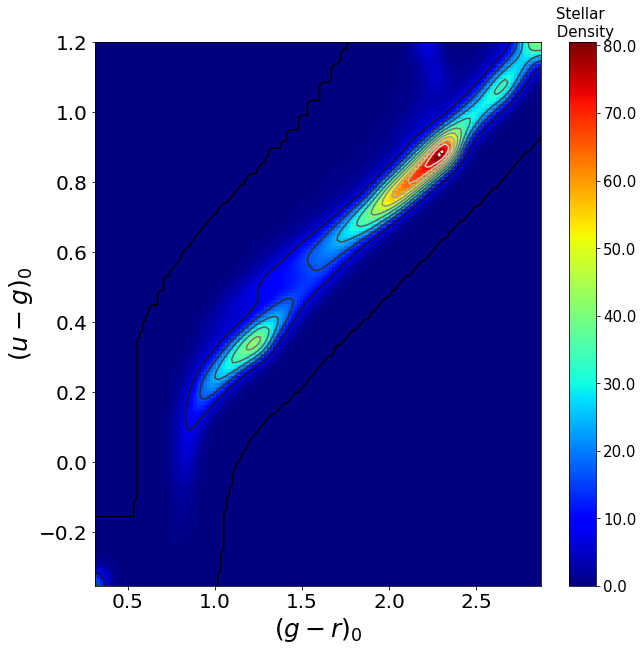

In [93]:
xx['iso'],yy['iso'],result['iso'],levels['iso'] = contour(u_g_des,g_r_des,150,150j,10)

### Overlap of 47tuc stars with original cal. sample

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  import sys


0

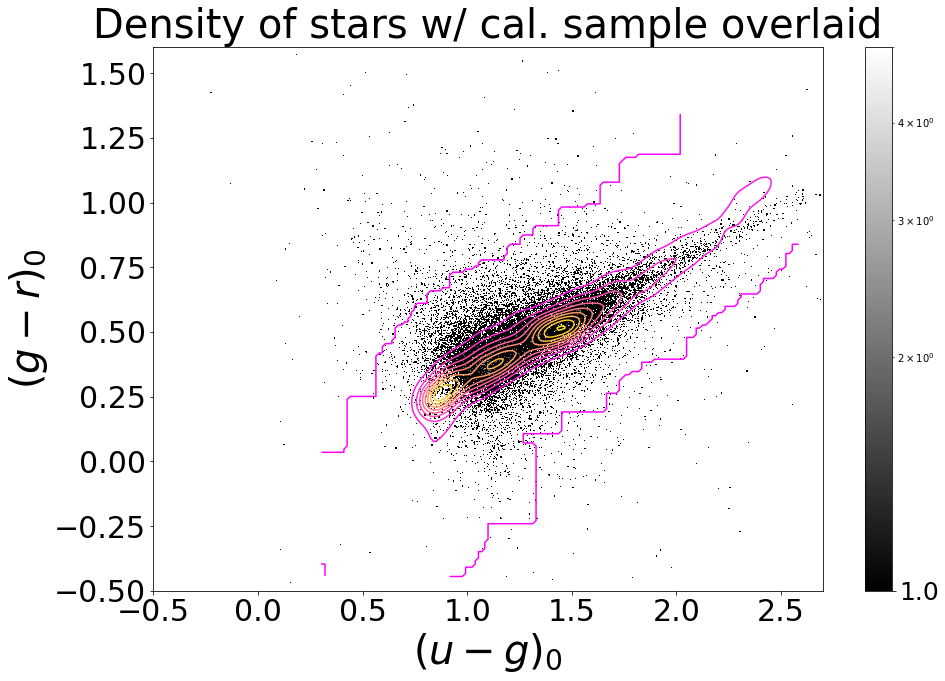

In [94]:
density(u_g_47,g_r_47,xx['cal'],yy['cal'],result['cal'],levels['cal'],5000)

0

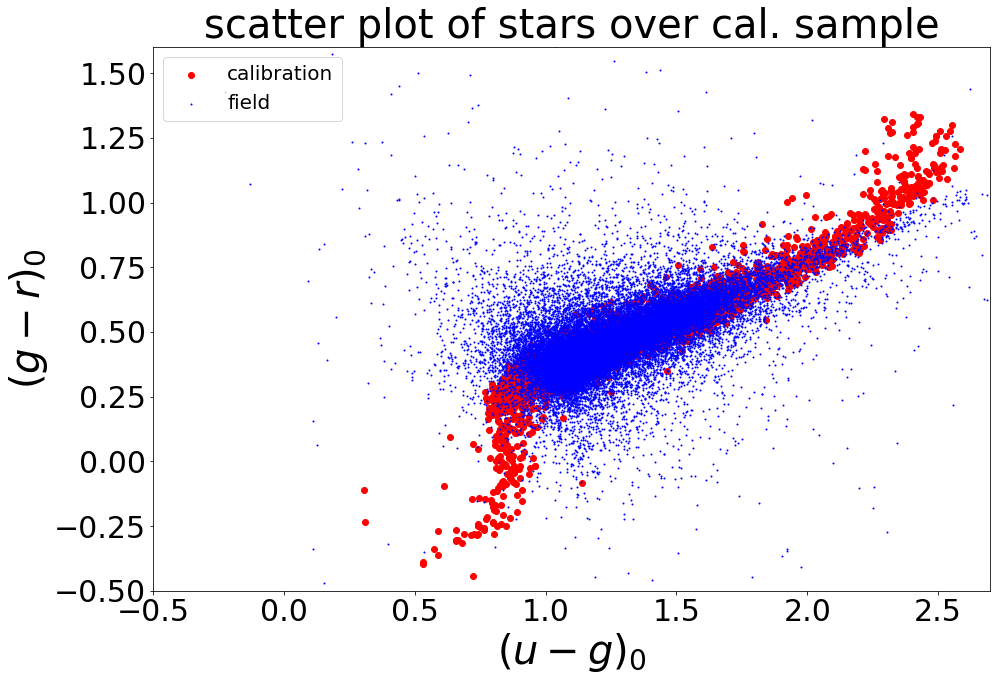

In [95]:
scatter(u_g_47,g_r_47,u_g_cal,g_r_cal)

### Overlap of 47tuc stars with parsec isochrone data

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  import sys


0

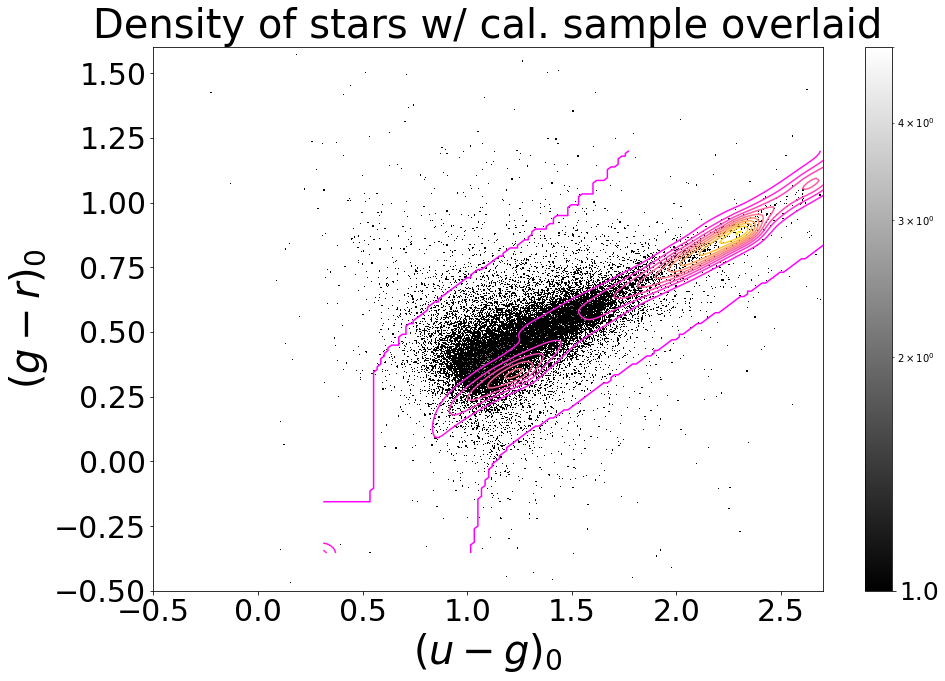

In [96]:
density(u_g_47,g_r_47,xx['iso'],yy['iso'],result['iso'],levels['iso'],5000)

0

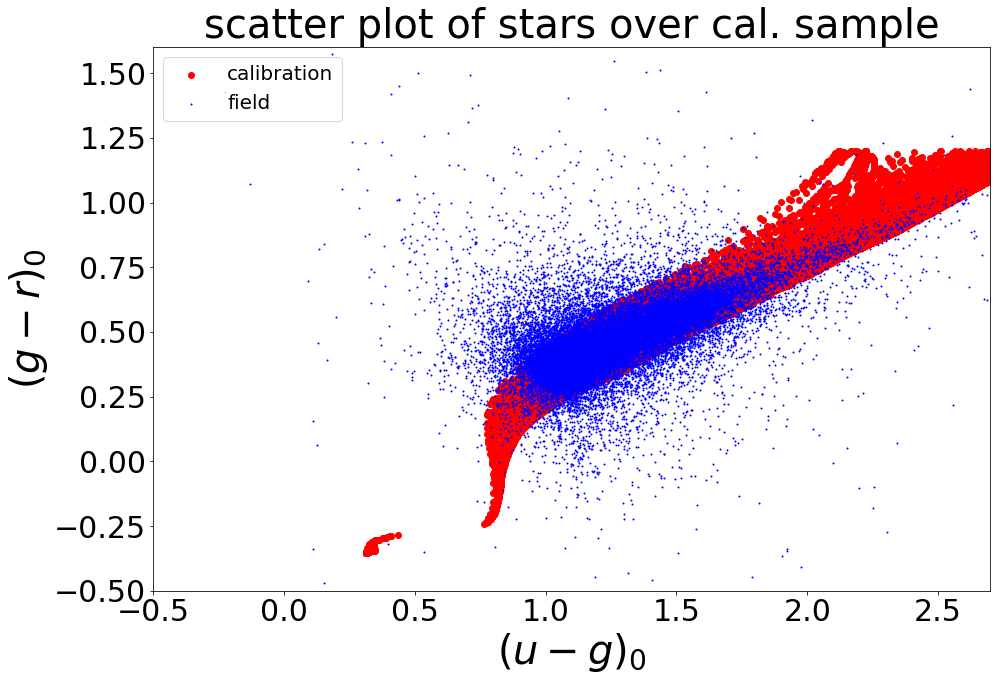

In [97]:
scatter(u_g_47,g_r_47,u_g_des,g_r_des)

### CMD of 47tuc

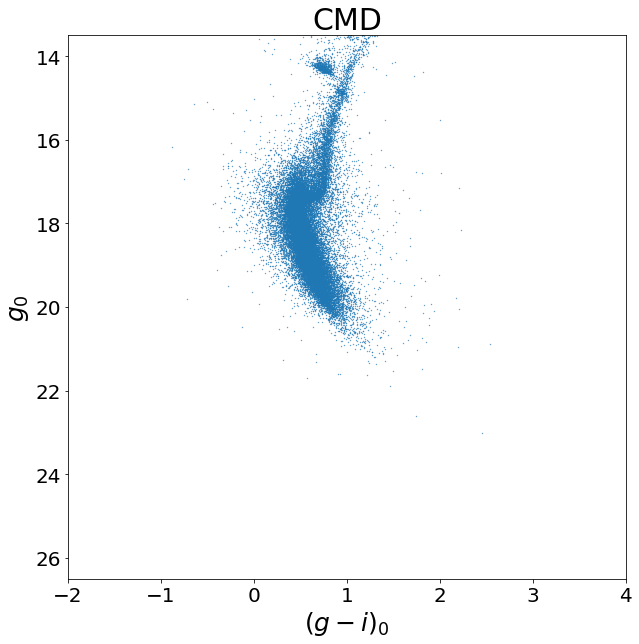

0

In [98]:
cmd(u_47,g_47,i_47)

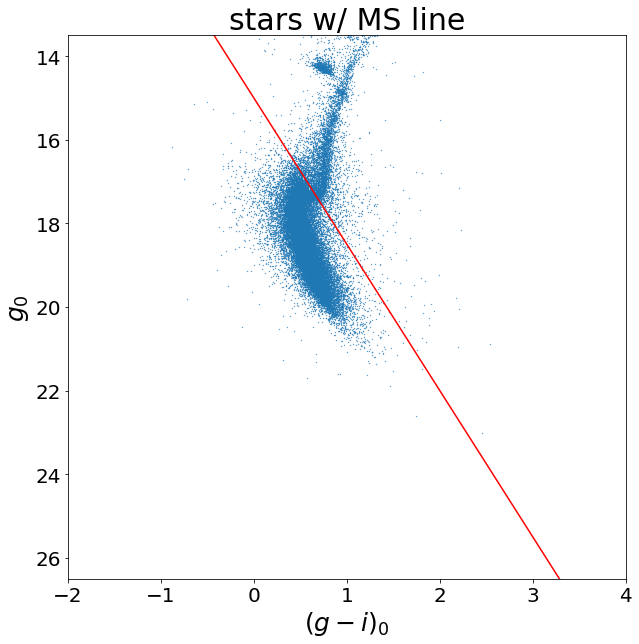

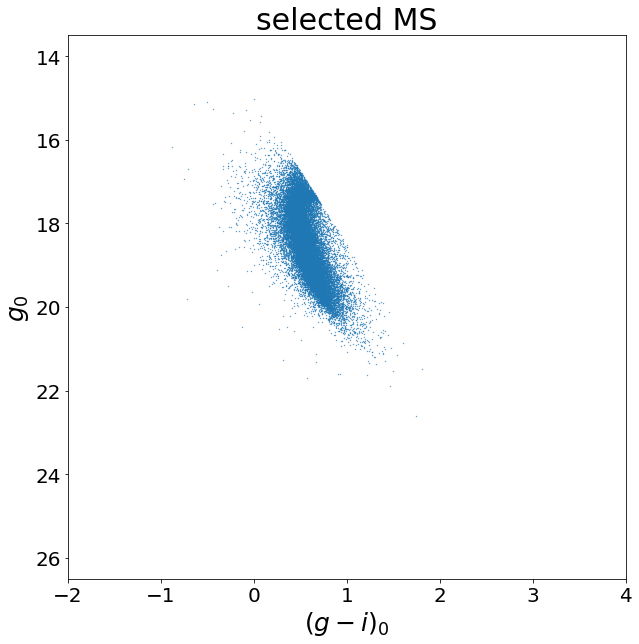

In [102]:
u_47,g_47,i_47,r_47 = select_MS(u_47,g_47,i_47,r_47,3.5,15)

0

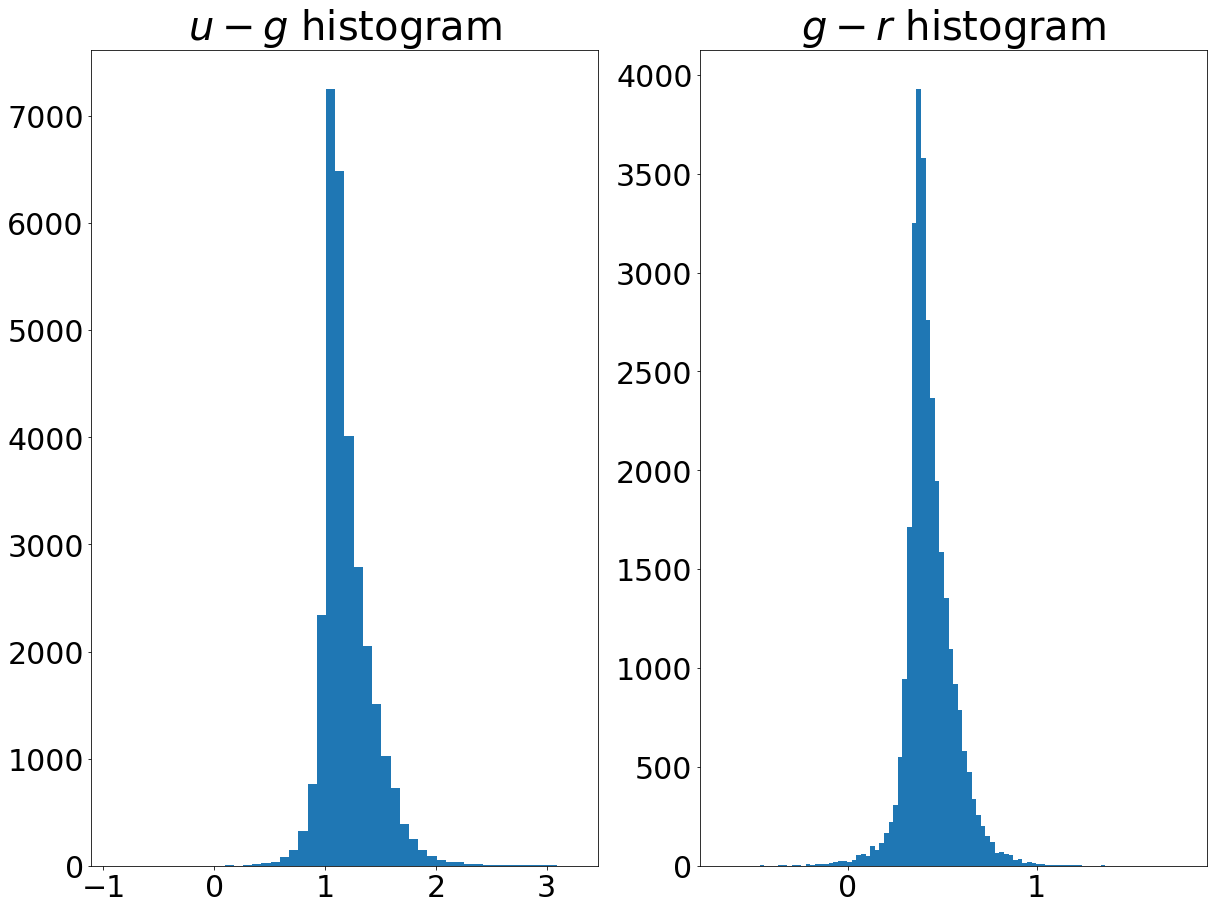

In [103]:
histograms((u_47-g_47),(g_47-r_47),'$u-g$','$g-r$')

In [104]:
ret = {}
xedge = {}
yedge = {}
bin = {}

In [105]:
ret['original'],xedge['original'],yedge['original'],bin['original'] = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)
ret['iso'],xedge['iso'],yedge['iso'],bin['iso'] = stats.binned_statistic_2d(u_g_des,g_r_des,feh_des,'median',100)    


In [106]:
feh_47 = {}

### Calculate metallicity with original calibration method

/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


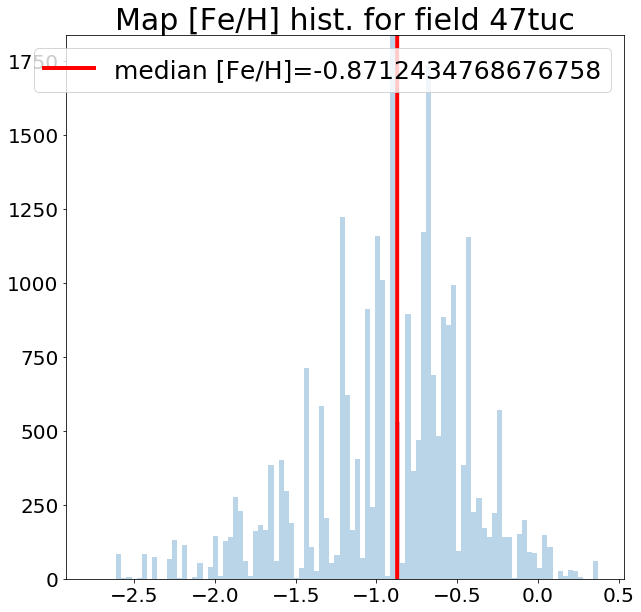

In [107]:
feh_47['og']=metallicity_map('47tuc',(u_47-g_47),(g_47-r_47),xedge['original'],yedge['original'],ret['original'])

In [108]:
print('median feh ',np.nanmedian(feh_47['og']))
print('diff WRT literature value, ',(-.75 - np.nanmedian(feh_47['og'])))

median feh  -0.8712434768676758
diff WRT literature value,  0.12124347686767578


### Take median $u-g$ and $g-r$ colors, and then calculate metallicity from original map

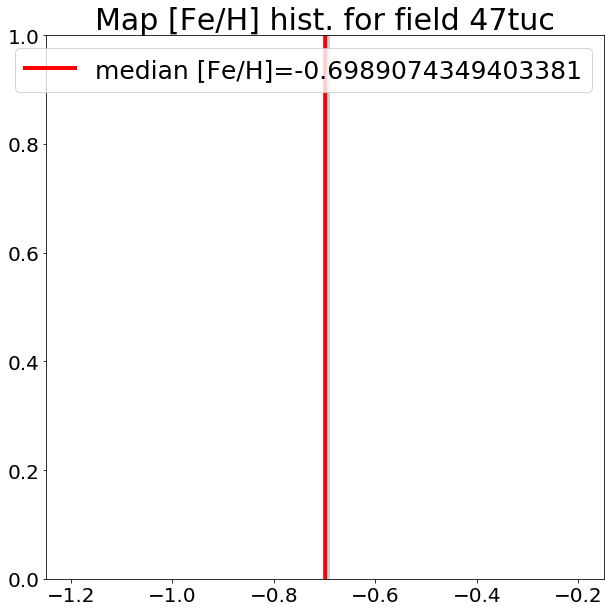

In [109]:
feh_47['og_color_median'] = metallicity_map_median('47tuc',np.median((u_47-g_47)),np.median((g_47-r_47)),xedge['original'],yedge['original'],ret['original'])


In [110]:
print('median feh ',np.nanmedian(feh_47['og_color_median']))
print('diff WRT literature value, ',(-.75 - np.nanmedian(feh_47['og_color_median'])))

median feh  -0.6989074349403381
diff WRT literature value,  -0.051092565059661865


### Use machine learning algorithm "nearest neighbors" to calculate metallicity of stars with original calibration sample

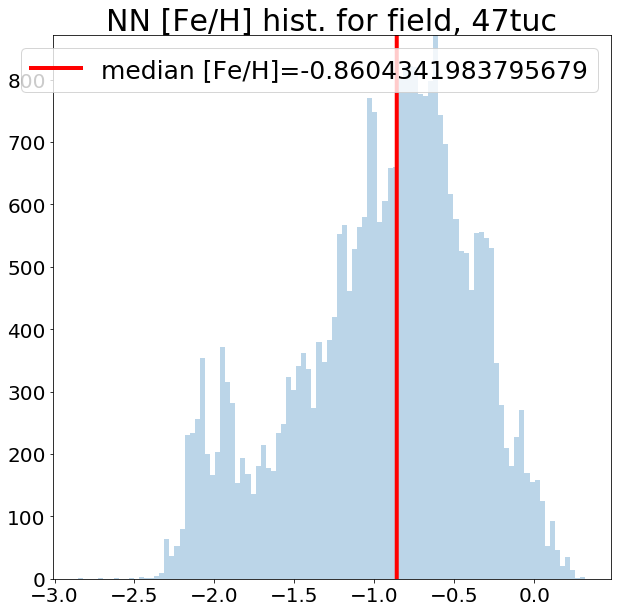

In [111]:
feh_47['og_nn']=metallicity_nn('47tuc',(u_47-g_47),(g_47-r_47),feh_cal,u_g_cal,g_r_cal,10)


In [112]:
print('median feh ',np.nanmedian(feh_47['og_nn']))
print('diff WRT literature value, ',(-.75 - np.nanmedian(feh_47['og_nn'])))

median feh  -0.8604341983795679
diff WRT literature value,  0.11043419837956792


### Take median colors of stars and then use NN algorithm to calculate metallicity

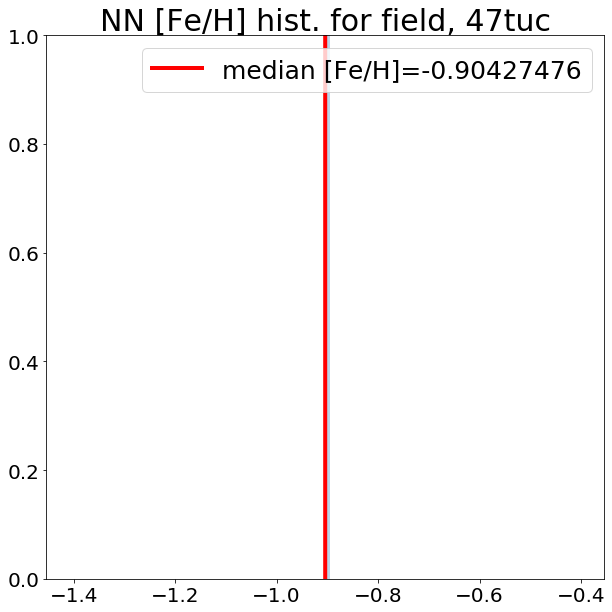

In [113]:
feh_47['og_nn_median'] = metallicity_nn('47tuc',[np.median((u_47-g_47))],[np.median((g_47-r_47))],feh_des,u_g_des,g_r_des,10)

#### Now, make all the same calculations, but using the PARSEC isochrone data as the calibration sample

/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


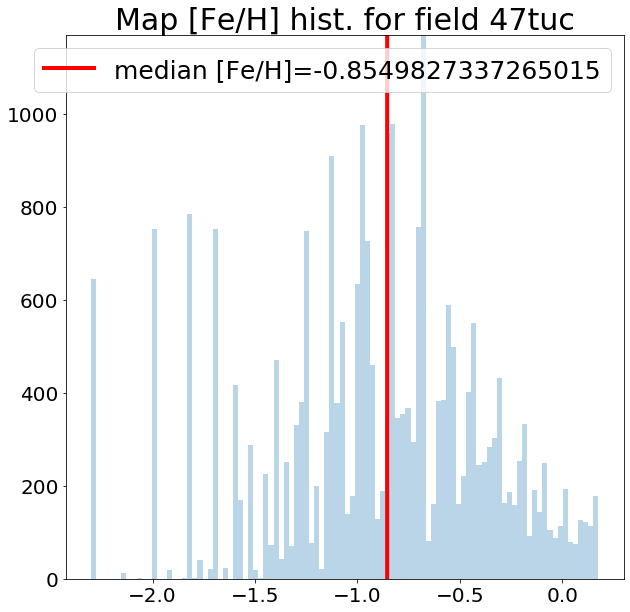

In [114]:
feh_47['iso']=metallicity_map('47tuc',(u_47-g_47),(g_47-r_47),xedge['iso'],yedge['iso'],ret['iso'])


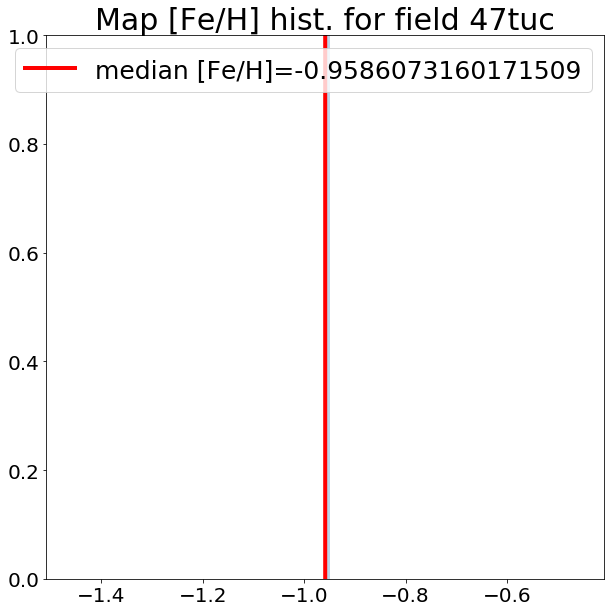

In [115]:
feh_47['iso_median'] = metallicity_map_median('47tuc',np.median((u_47-g_47)),np.median((g_47-r_47)),xedge['iso'],yedge['iso'],ret['iso'])


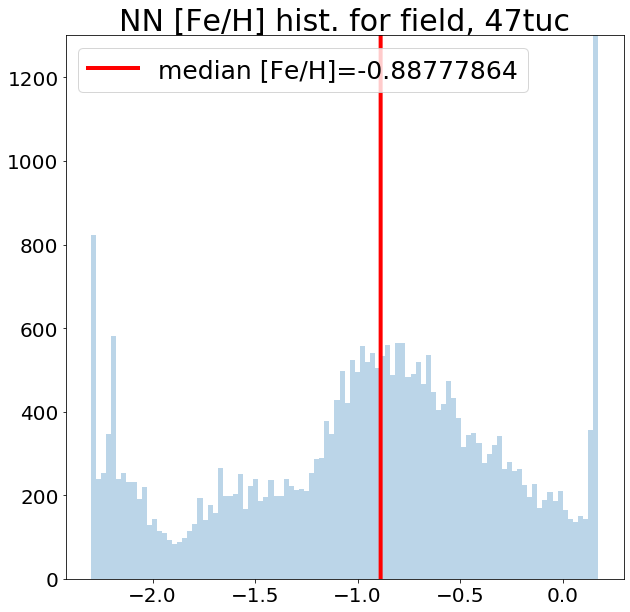

In [116]:
feh_47['iso_nn']=metallicity_nn('47tuc',(u_47-g_47),(g_47-r_47),feh_des,u_g_des,g_r_des,15)


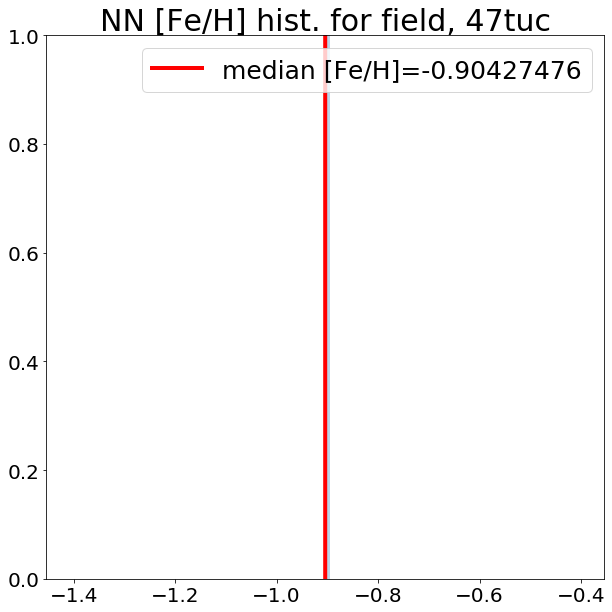

In [117]:
feh_47['iso_nn_median'] = metallicity_nn('47tuc',[np.median((u_47-g_47))],[np.median((g_47-r_47))],feh_des,u_g_des,g_r_des,10)


## Now NGC 362
### NGC 362 has [Fe/H] =-1.27,-1.15

reference: Global metallicity of globular cluster stars from colour–magnitude diagrams

In [118]:
#upload NGC 362 stars from SMASH catalogues
data = '/Users/amyel/research/SMASH_project/datafiles/NGC362_stars.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()
u_362,g_362,i_362,r_362 = deredden(objs["U"],objs["G"],objs["R"],objs["I"],objs["EBV"])

index = np.where((~np.isnan(u_362)) & (~np.isnan(g_362)) & (~np.isnan(i_362)) & (~np.isnan(r_362)))
u_362 = u_362[index]
g_362 = g_362[index]
i_362 = i_362[index]
r_362 = r_362[index]

index = np.where((u_362<=30) & (u_362>=-30) & (g_362<=30) & (g_362>=-30) & (i_362<=30) & (i_362>=-30) & (r_362<=30) & (r_362>=-30))
u_362 = u_362[index]
g_362 = g_362[index]
i_362 = i_362[index]
r_362 = r_362[index]



u_g_362 = u_362 - g_362
g_r_362 = g_362 - r_362

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  import sys


0

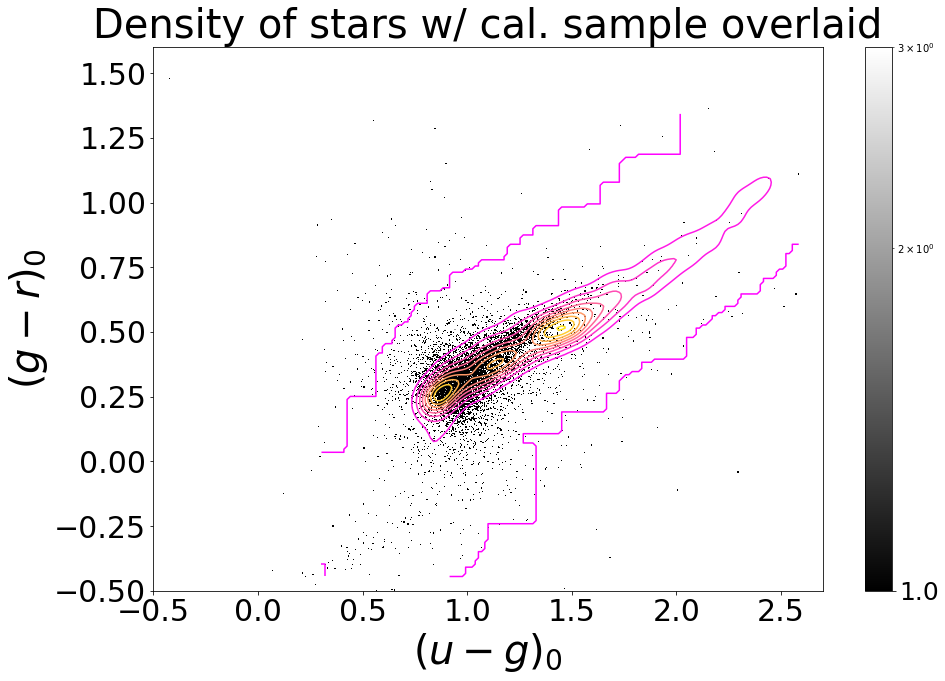

In [119]:
density(u_g_362,g_r_362,xx['cal'],yy['cal'],result['cal'],levels['cal'],5000)

0

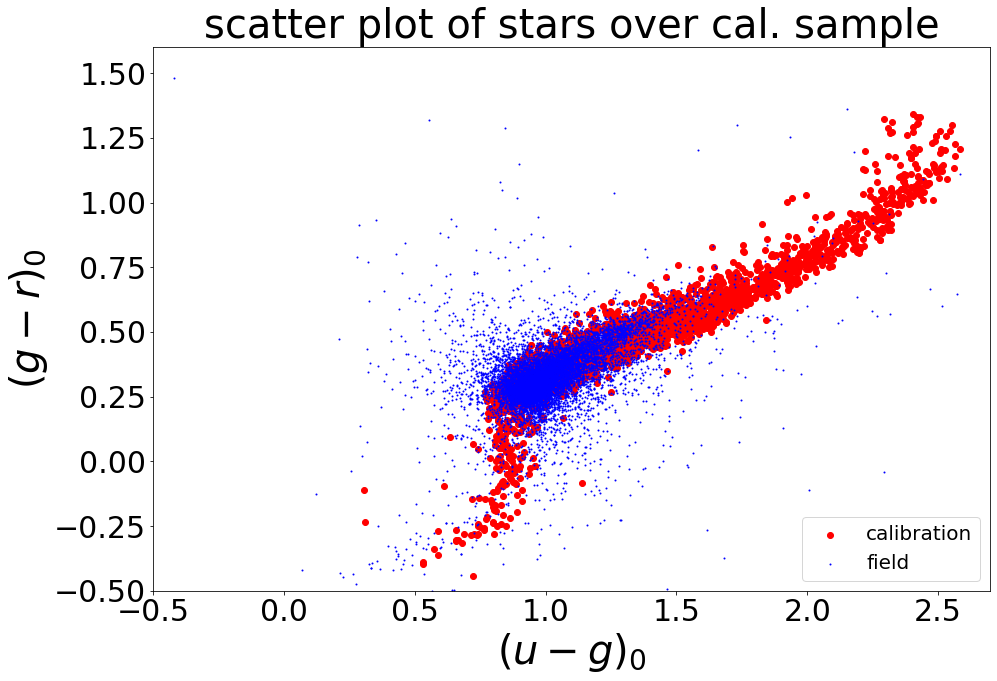

In [120]:
scatter(u_g_362,g_r_362,u_g_cal,g_r_cal)

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  import sys


0

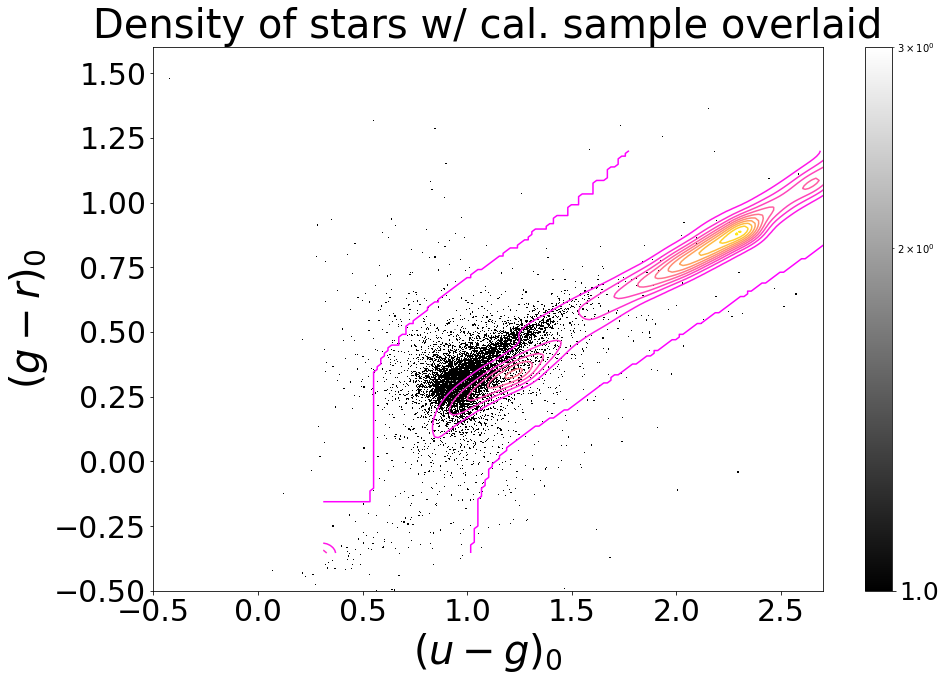

In [121]:
density(u_g_362,g_r_362,xx['iso'],yy['iso'],result['iso'],levels['iso'],5000)

0

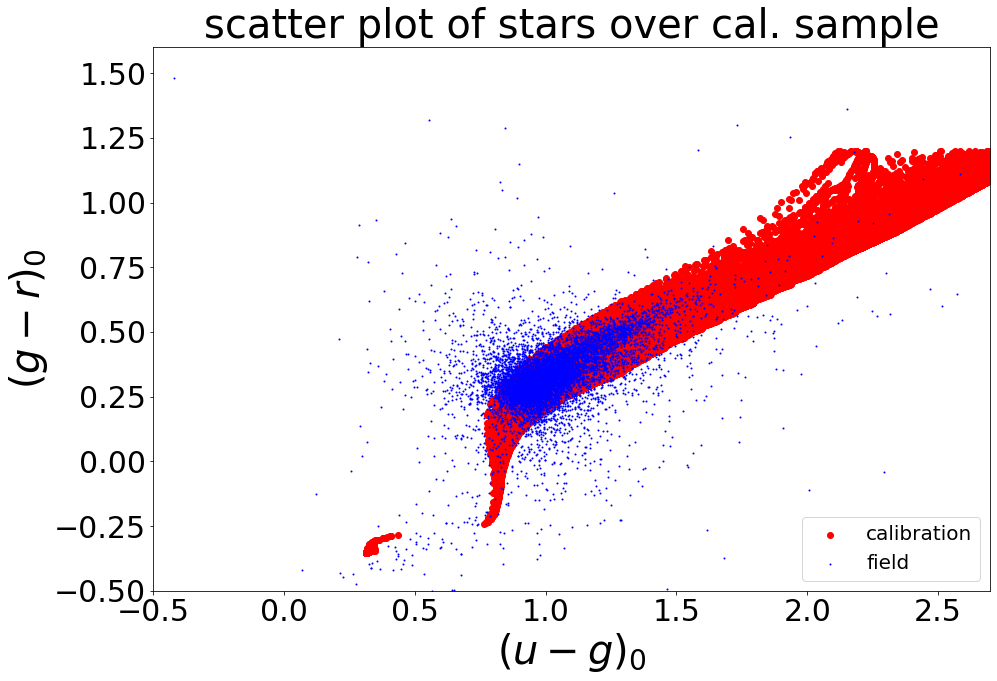

In [122]:
scatter(u_g_362,g_r_362,u_g_des,g_r_des)

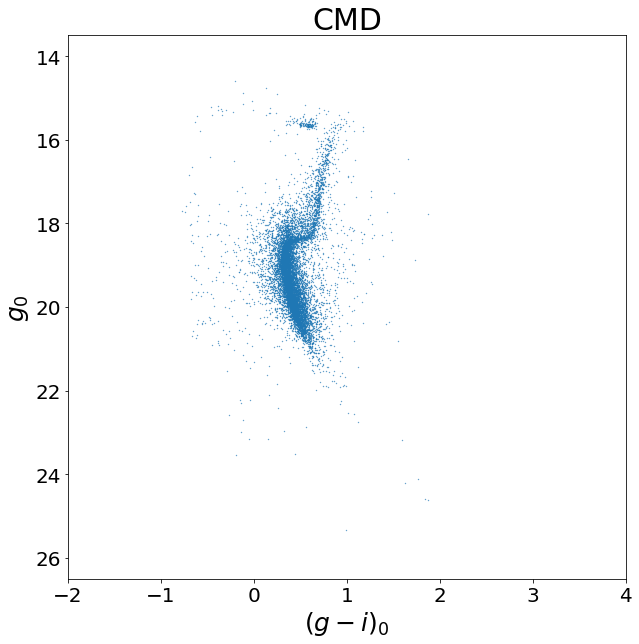

0

In [123]:
cmd(u_362,g_362,i_362)

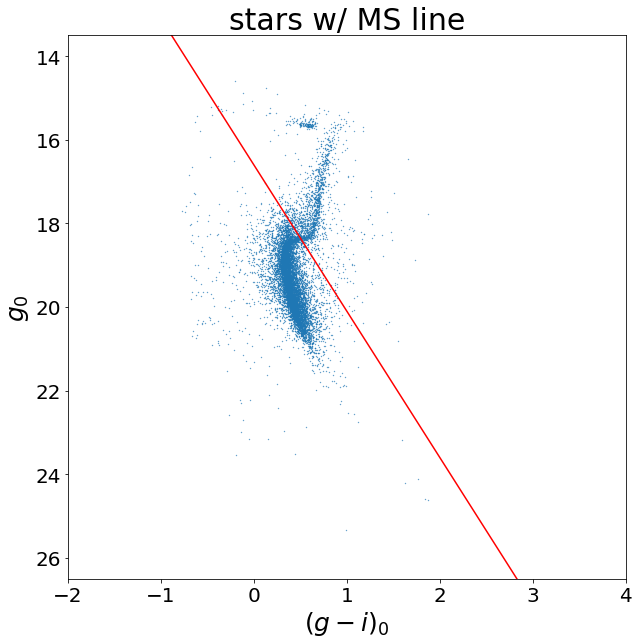

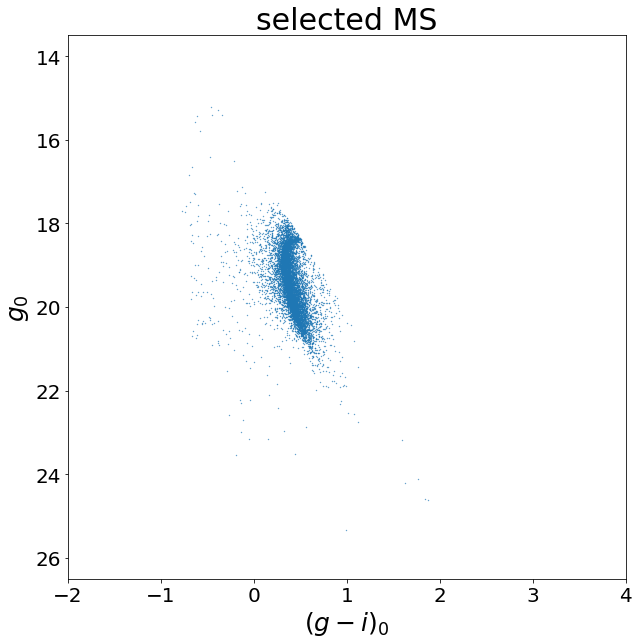

In [124]:
u_362,g_362,i_362,r_362 = select_MS(u_362,g_362,i_362,r_362,3.5,16.6)

0

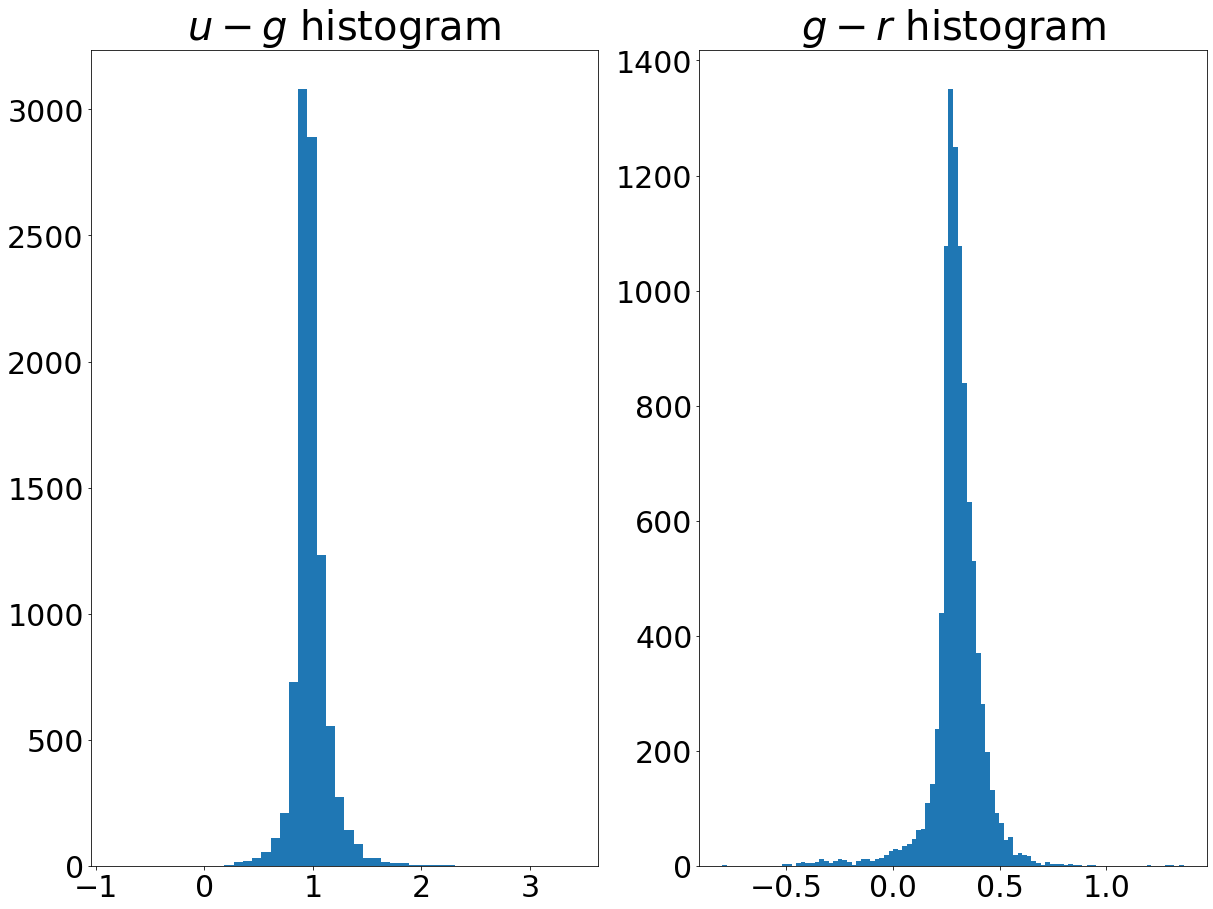

In [125]:
histograms((u_362-g_362),(g_362-r_362),'$u-g$','$g-r$')

In [126]:
feh_362 = {}

/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


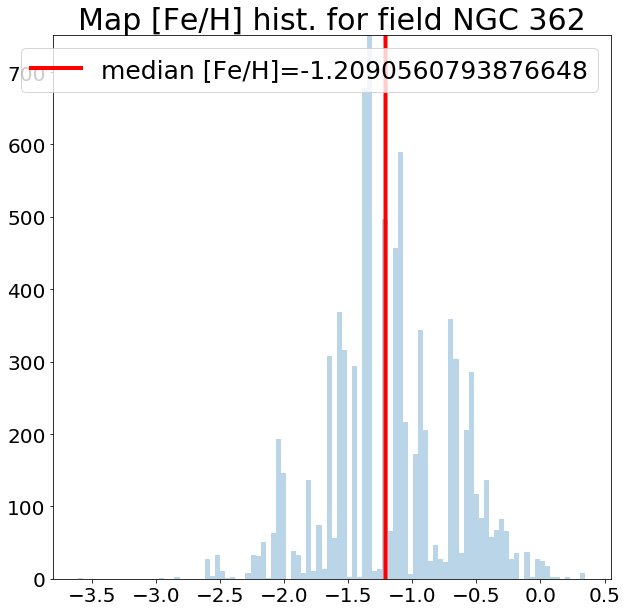

In [127]:
feh_362['og']=metallicity_map('NGC 362',(u_362-g_362),(g_362-r_362),xedge['original'],yedge['original'],ret['original'])

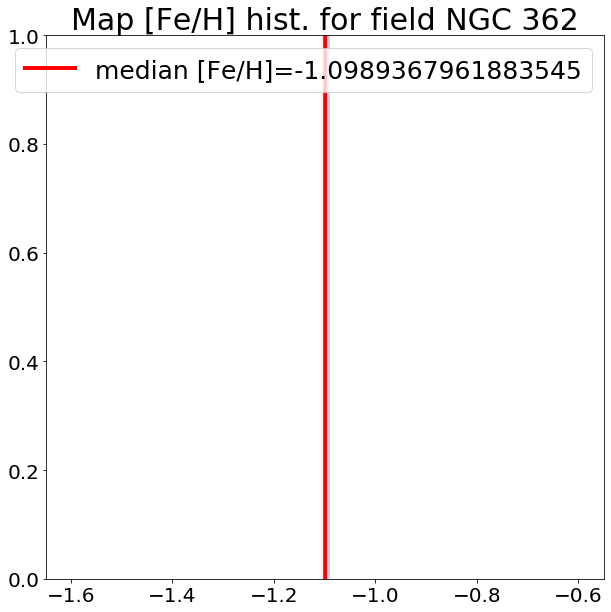

In [129]:
feh_362['og_color_median'] = metallicity_map_median('NGC 362',np.median((u_362-g_362)),np.median((g_362-r_362)),xedge['original'],yedge['original'],ret['original'])


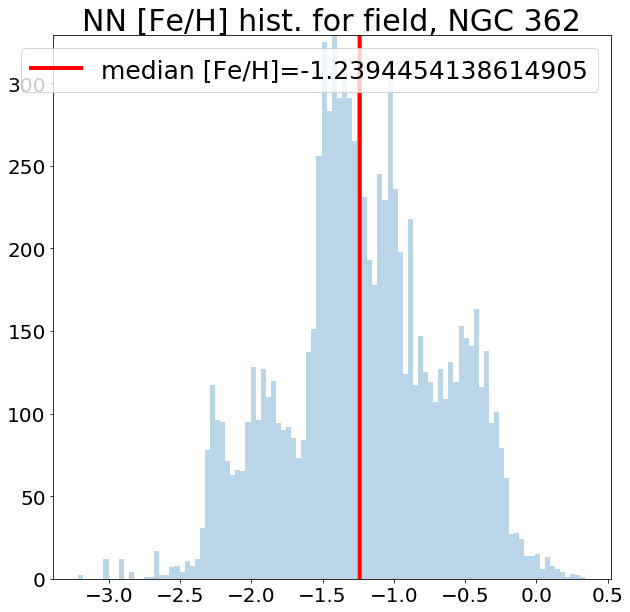

In [132]:
feh_362['og_nn']=metallicity_nn('NGC 362',(u_362-g_362),(g_362-r_362),feh_cal,u_g_cal,g_r_cal,7)


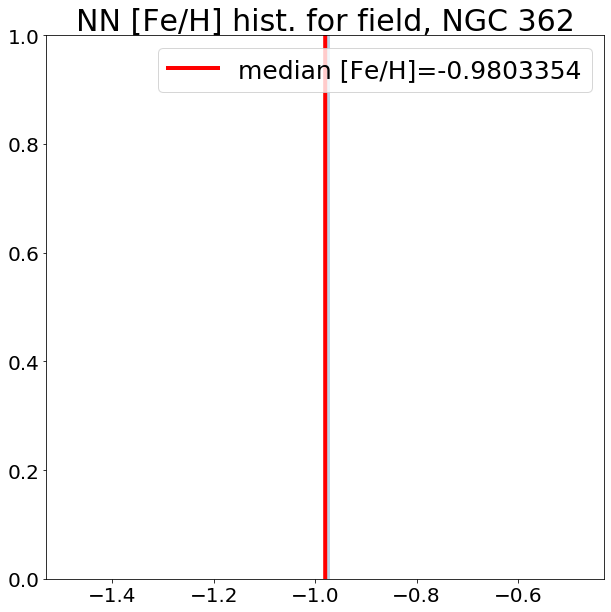

In [134]:
feh_362['og_nn_median'] = metallicity_nn('NGC 362',[np.median((u_362-g_362))],[np.median((g_362-r_362))],feh_des,u_g_des,g_r_des,10)

/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


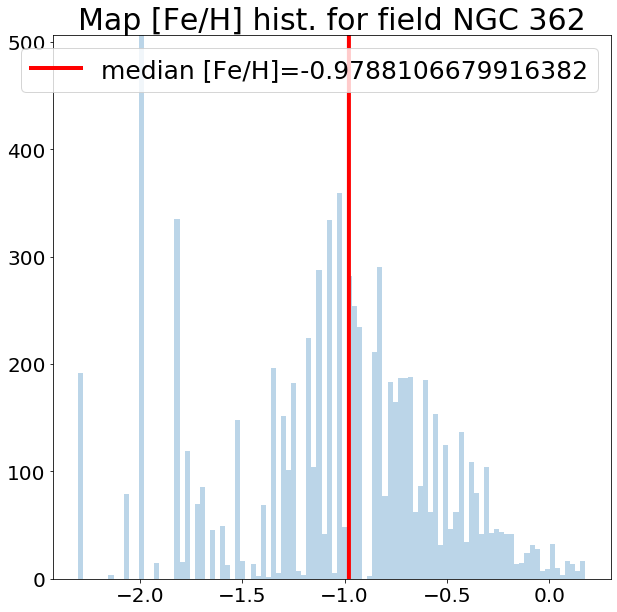

In [135]:
feh_362['iso']=metallicity_map('NGC 362',(u_362-g_362),(g_362-r_362),xedge['iso'],yedge['iso'],ret['iso'])


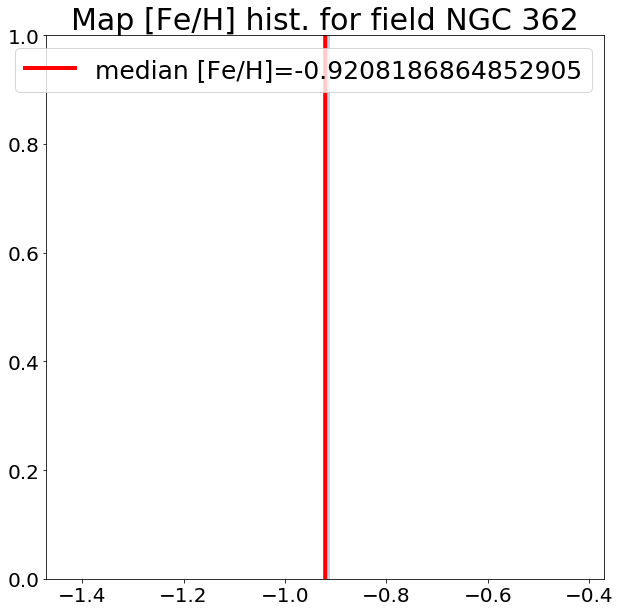

In [136]:
feh_362['iso_median'] = metallicity_map_median('NGC 362',np.median((u_362-g_362)),np.median((g_362-r_362)),xedge['iso'],yedge['iso'],ret['iso'])


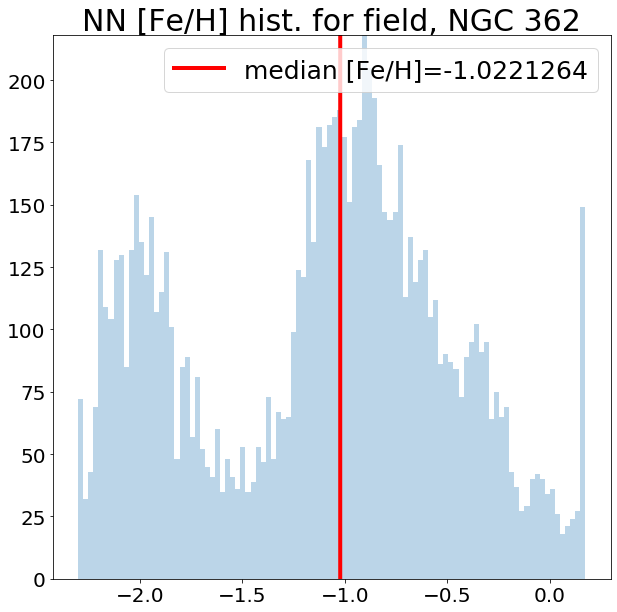

In [139]:
feh_362['iso_nn']=metallicity_nn('NGC 362',(u_362-g_362),(g_362-r_362),feh_des,u_g_des,g_r_des,12)


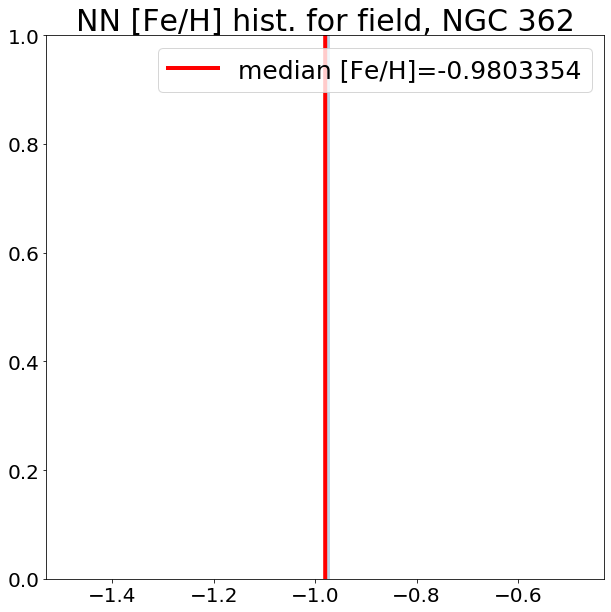

In [140]:
feh_362['iso_nn_median'] = metallicity_nn('NGC 362',[np.median((u_362-g_362))],[np.median((g_362-r_362))],feh_des,u_g_des,g_r_des,10)
